First, edit the paths in the following cell to point to the correct locations on your system.

If you don't want to deal with the aia error tables yet, you can always ignore that line and 
set real_aia_err=False in the dem call at the end of the notebook to use a flat uncertainty. 

In [1]:
#AIA Error table - set path to location in your system.
errortab='/Users/jessieduncan/ssw/sdo/aia/response/aia_V3_error_table.txt'

#Sunpy data directory (or wherever else you store your downloaded AIA data)
sunpy_dir='/Users/jessieduncan/sunpy/data/'

#Path to top-level do-dem directory - edit for your system.
path_to_dodem = '/Users/jessieduncan/do-dem/'
from sys import path as sys_path
sys_path.append(path_to_dodem+'/dodem/')

#do-dem
import lightcurves as lc
import region_fitting as rf
import nustar_dem_prep as nu
import dodem

#Basics
import numpy as np
import importlib
import matplotlib.pyplot as plt
from astropy import units as u

#Time
import matplotlib.dates as mdates
import astropy.time
import datetime

#File wrangling
import glob
import pickle
import os
import pathlib
os.getcwd()

'/Users/jessieduncan/do-dem'

First, let's take a look at the NuSTAR lightcurves.

Using time limits:
[datetime.datetime(2018, 5, 29, 22, 22), datetime.datetime(2018, 5, 29, 23, 20)]


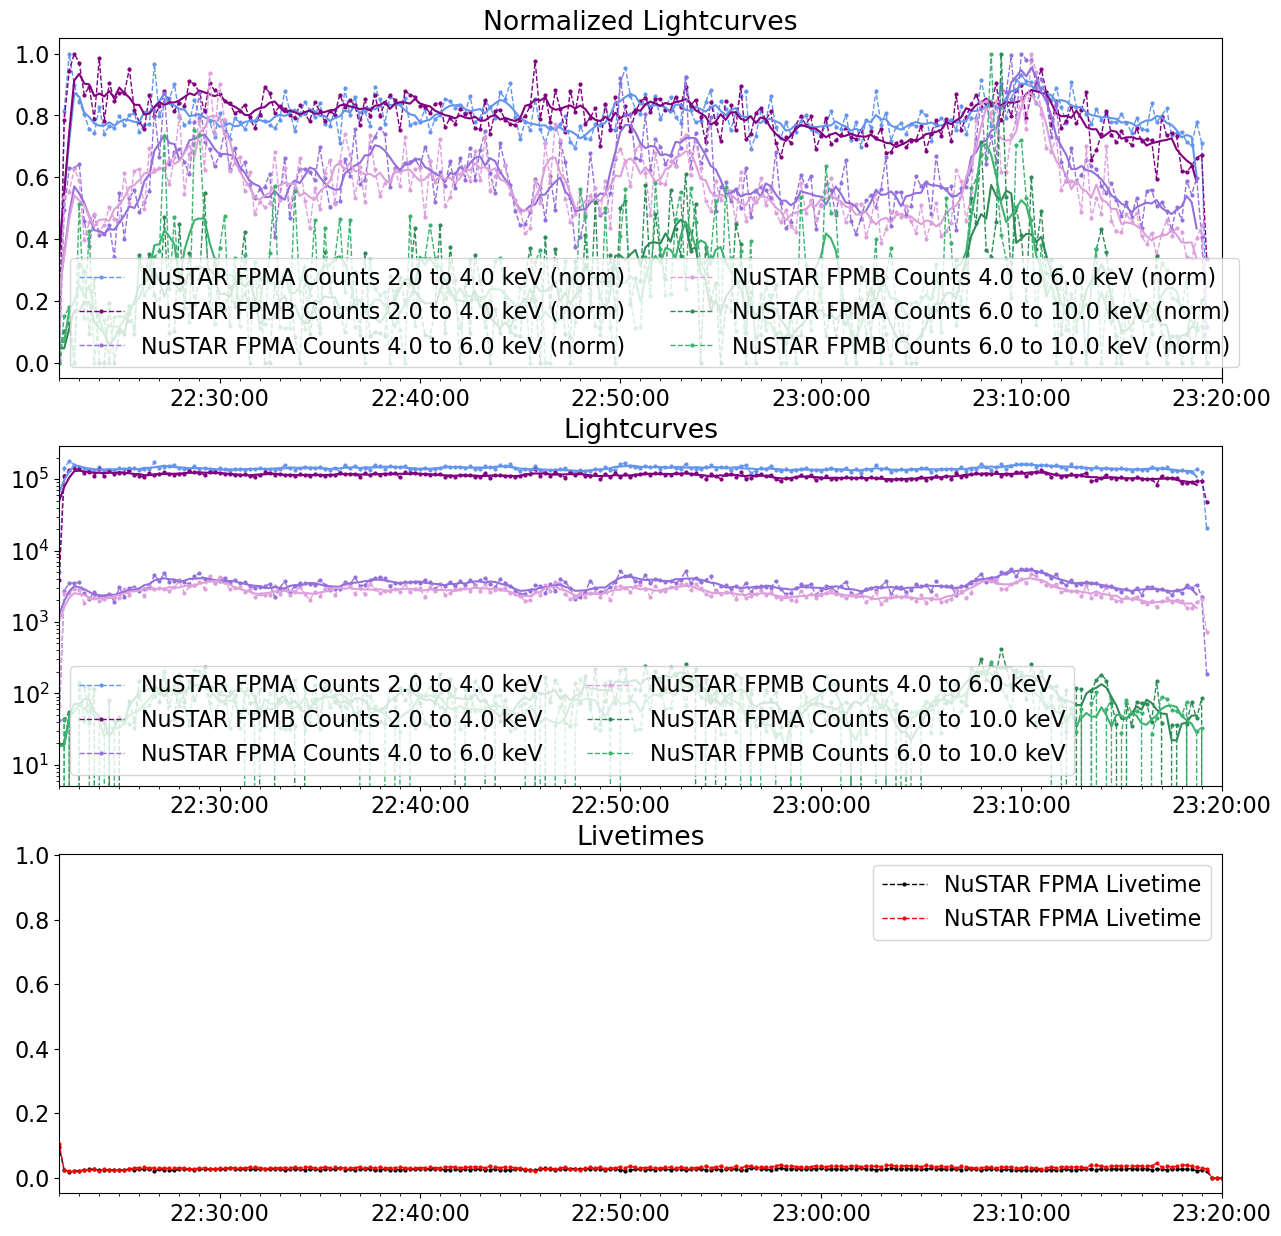

In [2]:
#Name your working directory
working_dir='./initial_dem/'

#Make a new working directory for prepped data/etc if it doesn't yet exist
save_path = pathlib.Path(working_dir)
if not save_path.exists():
    save_path.mkdir()

#Set path to obsid directory - initial pipeline should have been run already.
datapath='/Users/jessieduncan/nustar/may-2018/5_29pixpos/80410205001/'
obsid='80410205001'

#Edit+uncomment second line to include only the desired time interval (default- all times in file)
timerange=[]
timerange=[datetime.datetime(2018, 5, 29, 22, 22), datetime.datetime(2018, 5, 29, 23, 20)]

evtA = glob.glob(datapath+'/event_cl/*A06_cl.evt')
evtB = glob.glob(datapath+'/event_cl/*B06_cl.evt')
hkA  = glob.glob(datapath+'/hk/*A_fpm.hk')
hkB  = glob.glob(datapath+'/hk/*B_fpm.hk')

importlib.reload(lc)
lc.prepare_nustar_lightcurves(evtA, evtB, hkA, hkB, timebin=15, erange=[2.,4.], 
                              livetime_corr=True, save_dir=working_dir)
lc.prepare_nustar_lightcurves(evtA, evtB, hkA, hkB, timebin=15, erange=[4.,6.], 
                              livetime_corr=True, save_dir=working_dir)
lc.prepare_nustar_lightcurves(evtA, evtB, hkA, hkB, timebin=15, erange=[6.,10.], 
                              livetime_corr=True, save_dir=working_dir)

lc.plot_nustar_lightcurves(eranges = [[2.,4.],[4.,6.],[6.,10.]],
                           timerange=timerange, save_dir=working_dir)

Now, let's pick some initial time intervals for DEMs - how about every five minutes?

Note: later, you may want to make NuSTAR-statistics informed DEM intervals. Functionality for this is in nustar_dem_prep.find_intervals().

In [3]:
# #DEFINE ONE OR MORE 'MACRO INTERVALS' AND THEN MAKE SHORTER DEM TIME INTERVALS
macro_interval = [astropy.time.Time('2018-05-29T22:22:00', scale='utc', format='isot'),
                    astropy.time.Time('2018-05-29T23:19:00', scale='utc', format='isot')]

mins=5
time_intervals=[]
checktime = macro_interval[0]
while checktime < macro_interval[1]:
    time_intervals.append([checktime, checktime+mins*u.min])
    checktime = checktime+mins*u.min
    
    
count=0    
for t in time_intervals:
    print(count, t[0].strftime('%H-%M-%S'), t[1].strftime('%H-%M-%S'))
    count+=1



0 22-22-00 22-27-00
1 22-27-00 22-32-00
2 22-32-00 22-37-00
3 22-37-00 22-42-00
4 22-42-00 22-47-00
5 22-47-00 22-52-00
6 22-52-00 22-57-00
7 22-57-00 23-02-00
8 23-02-00 23-07-00
9 23-07-00 23-12-00
10 23-12-00 23-17-00
11 23-17-00 23-22-00


Now, for the first time interval, let's find a good NuSTAR DEM region. For starters, we'll use this for AIA (and XRT, if available) as well. Note that given the NuSTAR pointing uncertainty, it's probably not the best choice for an AIA/XRT region. However, we will use it for an initial run. 

In [4]:
# importlib.reload(nu)

gtifile=datapath+'event_cl/nu'+obsid+'A06_gti.fits'
regfile=path_to_dodem+'starter_region.reg'
time_interval=time_intervals[0]

# nu.make_nustar_products(time_interval, 'A', gtifile, datapath, regfile, working_dir, edit_regfile=True,
#                         nofit=True, pile_up_corr=True, clobber=False, nuradius=150, path_to_dodem=path_to_dodem)

Now, we'll take the NuSTAR output region file and use it to make a dictionary that will be used to create a region object for AIA/XRT in the DEM data prep stage.

In [5]:
timestring = time_interval[0].strftime('%H-%M-%S')
stopstring = time_interval[1].strftime('%H-%M-%S')
timestring=timestring+'_'+stopstring
    
regfile=working_dir+timestring+'/nu'+obsid+'A06_0_p_cl_sunpos_COM_region.reg'
offset, rad = rf.read_regfile(regfile, time_interval[0], time_interval[1], 'hourangle')
print(offset)
print(rad)

xx = offset[0].value
yy = offset[1].value

[-60.09296956 253.1244629 ] arcsec
150.0 arcsec


In [6]:
#Set broad box for plotting (using region object)
bl=[(xx-200)*u.arcsec, (yy-200)*u.arcsec]
tr=[(xx+200)*u.arcsec,(yy+200)*u.arcsec]
print(tr[0]-bl[0], tr[1]-bl[1])

#Make region dictionary 
region_input = {'center': (xx,  yy)*u.arcsec,
                  'radius': rad}

400.0 arcsec 400.0 arcsec


Now, let's set some other DEM input parameters (chosing which instruments to use, NuSTAR DEM energies, etc).

In [7]:
#What instruments are you using?
#---------------------------------
aia=True
#---------------------------------
eis=False
#---------------------------------
xrt=False
plot=False
#Here is the exposure time limits dictionary for each XRT filter combination:
exposure_dict={'Be_thin': [1*u.s, 10*u.s],
                'Be_med': [],
              'Al_poly': [0.1*u.s, 1*u.s]}
#---------------------------------
nustar=True
#If nustar is being used, here are the chosen energy ranges:
nuenergies=[[2.5,3.5],[3.5,6.], [6.,10.]]
#---------------------------------

#---------------------------------
#---------------------------------
#What temperature range would you like to use? (units: log(T))
minT=5.6
maxT=7.2

#Would you prefer to plot temperatures in MK, or the default (logT)
plotMK=False
#---------------------------------
#---------------------------------

name='initial_dem'

Note: sometimes, when running the DEM prep for the first time, there will be issues with the AIA data download via Fido.search and .fetch. This often seems to be resolvable by just repeating the same attempted download. To save time, aia_dem_prep.aia_for_DEM() can be used in isolation (see function for needed keywords) to avoid having to run all the other instrument prep as well by running it through the full dodem function. 

In [8]:
# #NuSTAR and AIA DEM
# dodem.dodem(time_interval, bl, tr, xrt=xrt, aia=aia, nustar=nustar, name=name,
#                                     plotMK=plotMK, plot=plot, minT=minT, maxT=maxT,
#                                     plotresp=False, working_directory=working_dir,
#                                     default_err=0.2, path_to_dodem=path_to_dodem,
            
#                                     #demreg related
#                                     rgt_fact=1.2, max_iter=30,
#                                     reg_tweak=1, gloci=1, mc_in=True, mc_rounds=100, 
                                    
#                                     #nustar related 
#                                     combine_fpm=True,nuenergies=nuenergies, make_nustar=True, 
#                                     datapath=datapath, gtifile=gtifile,
#                                     COM_nustar_region=True, nuclobber=False, edit_regfile=True,
            
#                                     #aia related
#                                     aiamethod='Auto', real_aia_err=True,
#                                     input_aia_region="circle", input_aia_region_dict=region_input,
#                                        sunpy_dir=sunpy_dir, errortab=errortab)


Adding XRT: this requires a directory (xrt_path) containing level-1 XRT data and grade map files for times/pointings consistent with the NuSTAR data.

Start Time:  2018-05-29T22:22:00.000
Stop Time:  2018-05-29T22:27:00.000
You provided both a region box and a specific region.
Bounding box will be used only for initial data prep (will save submap instead of full disk);
specific region will be used for DEM



NameError: name 'colors' is not defined

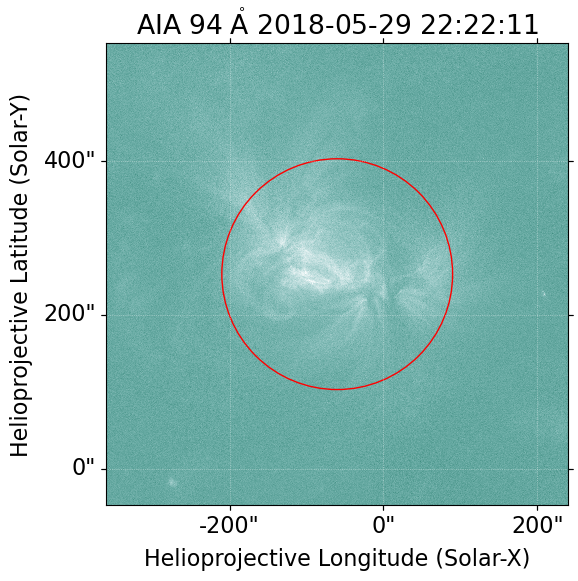

In [9]:
xrt_path=working_dir+'/XRT_for_DEM/'
xrt=True
plot=True

#NuSTAR and AIA DEM
dodem.dodem(time_interval, bl, tr, xrt=xrt, aia=aia, nustar=nustar, name=name,
                                    plotMK=plotMK, plot=plot, minT=minT, maxT=maxT,
                                    plotresp=False, working_directory=working_dir,
                                    default_err=0.2, path_to_dodem=path_to_dodem,
            
                                    #demreg related
                                    rgt_fact=1.2, max_iter=30,
                                    reg_tweak=1, gloci=1, mc_in=True, mc_rounds=100, 
                                    
                                    #nustar related 
                                    combine_fpm=True,nuenergies=nuenergies, make_nustar=True, 
                                    datapath=datapath, gtifile=gtifile,
                                    COM_nustar_region=True, nuclobber=False, edit_regfile=True,
            
                                    #aia related
                                    aiamethod='Auto', real_aia_err=True,
                                    input_aia_region="circle", input_aia_region_dict=region_input,
                                       sunpy_dir=sunpy_dir, errortab=errortab,
           
           
                                   #xrt related
                                   xrtmethod='Average', real_xrt_err=True, xrt_path=xrt_path,
                                    input_xrt_region="circle", input_xrt_region_dict=region_input)

